IMPORTS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from scipy.stats import randint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Importando os conjuntos da base de dados

In [2]:
test_path = "../test_normalized.csv"
val_path = "../val_normalized.csv"
subtrain_path = "../train_normalized.csv"

df_val = pd.read_csv(val_path, index_col=0)
df_test = pd.read_csv(test_path, index_col=0)
df_subtrain = pd.read_csv(subtrain_path, index_col=0)

In [3]:
print("Validação:", df_val.shape)
print("Teste:", df_test.shape)
print("Sub-conjunto de treinamento", df_subtrain.shape)

Validação: (12600, 22)
Teste: (18900, 22)
Sub-conjunto de treinamento (13500, 22)


In [ ]:
X_train_subset = df_subtrain.iloc[:, :-1]
y_train_subset  = df_subtrain.iloc[:, -1] 

X_val = df_val.iloc[:, :-1]
y_val = df_val.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# Unificando os conjuntos de subtreino e validação
X_train = pd.concat([X_train_subset, X_val], axis=0)
y_train= pd.concat([y_train_subset, y_val], axis=0)

# Achando os melhores hiperparâmetros

In [5]:
# Definindo o modelo LightGBM
modelo_lgbm = lgb.LGBMClassifier(random_state=42)

# Hiperparâmetros que serão ajustados
param_dist = {
    'num_leaves': randint(20, 150), 
    'max_depth': randint(1, 21), 
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'n_estimators': randint(50, 200),  
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0] 
}

# Listas para armazenar os resultados
melhores_modelos = []
historico_mean_scores = []  
historico_std_scores = []   
historico_acuracia_val = [] 

# Executar o RandomizedSearchCV 20 vezes
for i in range(20):  
    print(f"Executando RandomizedSearchCV {i+1}/20...")

    random_search = RandomizedSearchCV(
        modelo_lgbm, 
        param_distributions=param_dist, 
        n_iter=1,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  
        n_jobs=-1,  
        random_state=i,
        scoring='accuracy',
        return_train_score=True
    )

    random_search.fit(X_train_subset, y_train_subset)

    # Média e desvio-padrão das 5 folds na validação cruzada
    mean_scores = random_search.cv_results_['mean_test_score'] 
    std_scores = random_search.cv_results_['std_test_score']

    # Armazena a média e desvio padrão das iterações
    historico_mean_scores.append(np.mean(mean_scores))
    historico_std_scores.append(np.mean(std_scores))
    
    # Dentre os 5 folds, qual teve a melhor nota
    melhor_modelo = random_search.best_estimator_
    
    # Avaliar o melhor modelo no conjunto de validação
    y_val_pred = melhor_modelo.predict(X_val)
    acuracia_val = accuracy_score(y_val, y_val_pred)
    
    melhores_modelos.append(melhor_modelo)
    historico_acuracia_val.append(acuracia_val)

# Escolher o melhor modelo baseado na melhor acurácia no conjunto de validação
indice_melhor = np.argmax(historico_acuracia_val)
melhor_modelo_final = melhores_modelos[indice_melhor]

print(f"\nMelhor acurácia no conjunto de validação: {historico_acuracia_val[indice_melhor]:.4f}")
print(f"🌟 Melhores parâmetros encontrados: {random_search.best_params_}")


Executando RandomizedSearchCV 1/20...


C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 13500, number of used features: 21
[LightGBM] [Info] Start training from score -7.564535
[LightGBM] [Info] Start training from score -0.200621
[LightGBM] [Info] Start training from score -1.707827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

Plot e resultados da busca de hiperparâmetros

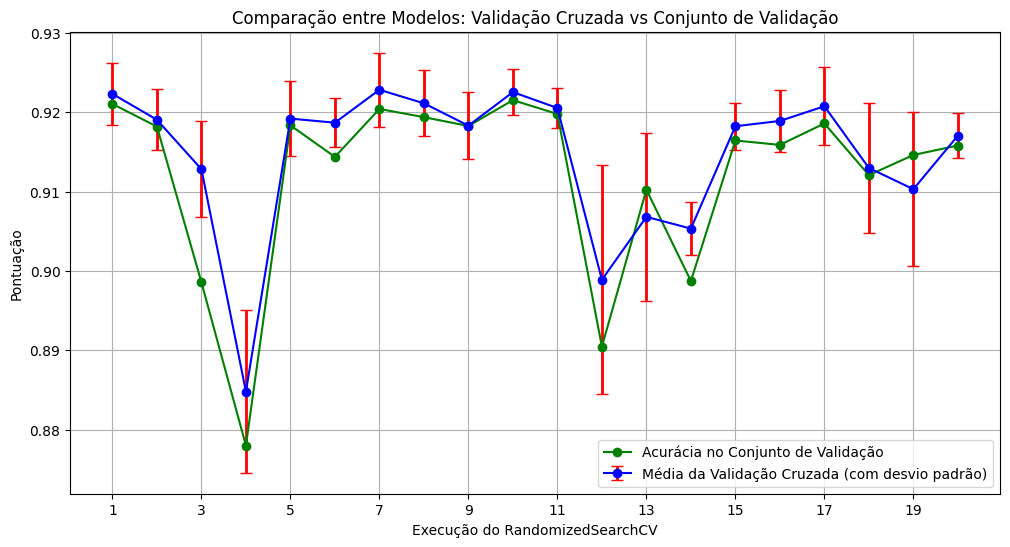

In [6]:
# Criando gráfico com duas linhas
plt.figure(figsize=(12, 6))

# Linha azul: Média da validação cruzada + barras de erro (desvio padrão)
plt.errorbar(
    range(1, len(historico_mean_scores) + 1), 
    historico_mean_scores, 
    yerr=historico_std_scores, 
    fmt='o-',  
    color='b', 
    ecolor='r',  
    elinewidth=2, 
    capsize=4, 
    label='Média da Validação Cruzada (com desvio padrão)'
)

# Linha verde: Acurácia do modelo no conjunto de validação
plt.plot(
    range(1, len(historico_acuracia_val) + 1), 
    historico_acuracia_val, 
    'g-o',  
    label='Acurácia no Conjunto de Validação'
)

# Adicionando título e rótulos
plt.xlabel('Execução do RandomizedSearchCV')
plt.ylabel('Pontuação')
plt.title('Comparação entre Modelos: Validação Cruzada vs Conjunto de Validação')
plt.xticks(range(1, len(historico_mean_scores) + 1, max(1, len(historico_mean_scores) // 10)))  # Ajusta os ticks
plt.grid(True)
plt.legend()

# Exibir o gráfico
plt.show()


# Treinando e testando o modelo

In [7]:
melhor_modelo.fit(X_train, y_train)

y_pred = melhor_modelo.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro') 
recall = recall_score(y_test, y_pred, average='macro') 
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 26100, number of used features: 21
[LightGBM] [Info] Start training from score -7.771795
[LightGBM] [Info] Start training from score -0.206473
[LightGBM] [Info] Start training from score -1.681308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Acurácia: 0.9165
Precisão: 0.5982
Recall: 0.5441
F1-Score: 0.5658


C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Matriz de confusão


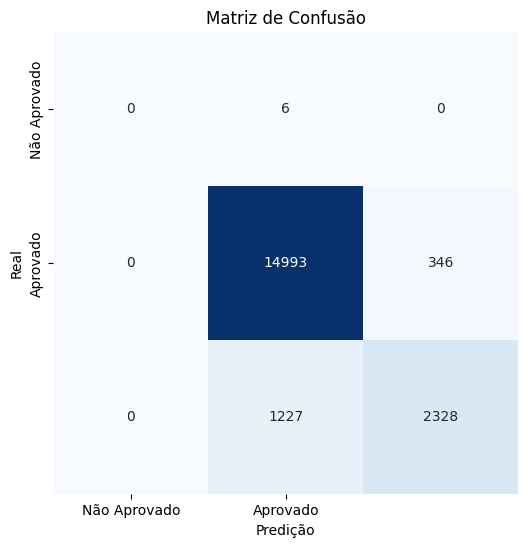

In [8]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Não Aprovado', 'Aprovado'], yticklabels=['Não Aprovado', 'Aprovado'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()